In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_video(path:str) -> list:
    video_cap = cv2.VideoCapture(path)

    if not video_cap.isOpened():
        raise ValueError("Could not open video file")

    frames = list()
    while True:
        ret, frame = video_cap.read()
        if not ret:
            break 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return frames

def crop_center(frame, margin: float = 0.05) -> np.ndarray:
    height, width, _ = frame.shape 

    x_center = height  // 2
    y_center = width // 2

    x_margin = int(height * margin)
    y_margin = int(width * margin)

    cropped_frame = frame[
        x_center - x_margin: x_center + x_margin, 
        y_center - y_margin : y_center + y_margin]

    return cropped_frame

def create_osd_mask(frame, background, threshold_value=30):
    kernel_size = (5, 5)    
    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    
    # Calculate absolute difference between frame and background
    frame_diff = cv2.absdiff(frame_gray, background_gray)
    plt.imshow(frame_diff)
    plt.show()
    
    # Apply thresholding
    _, binary_mask = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Perform morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    return binary_mask

def remove_OSD(frame) -> np.ndarray:
    blur = cv2.blur(frame, (5, 5))
    return blur
    

In [3]:
video_path = '../assets/test_video.mp4'
video = read_video(video_path)

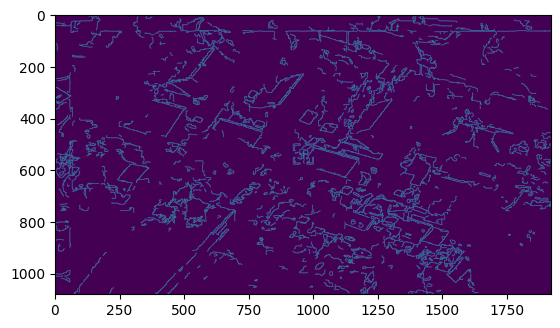

In [21]:
edges = cv2.Canny(video[0],50,150,apertureSize = 3)

plt.imshow(edges)

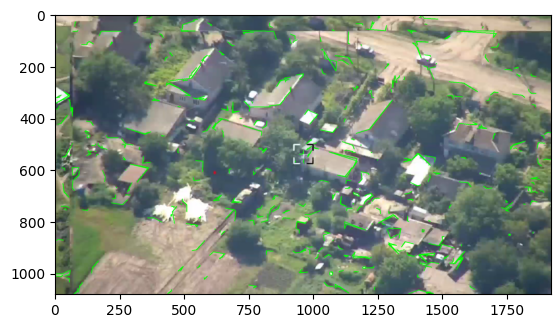

In [23]:
frame = video[0]
# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and draw rectangles around detected contours
for contour in contours:
        # Approximate the contour to a rectangle
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
        
    if len(approx) == 4:
            # If the contour has 4 vertices (a rectangle), draw it
        cv2.drawContours(frame, [approx], 0, (0, 255, 0), 2)

plt.imshow(frame)

In [24]:
import random
mean_frame = np.mean(random.sample(video, int(len(video) * 0.4)), axis=0).astype(np.uint8)

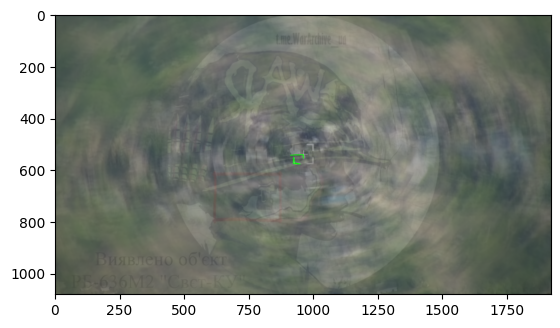

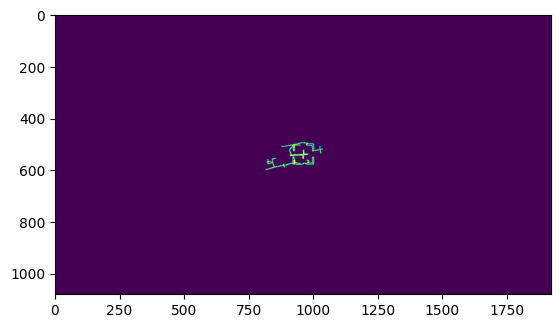

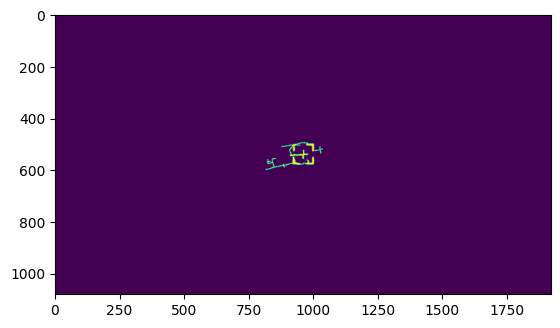

In [47]:
plt.imshow(mean_frame)
plt.show()

edges = cv2.Canny(mean_frame, 30, 150,apertureSize = 3)

# Create a kernel for dilation
kernel = np.ones((3, 3), np.uint8)

# Perform morphological dilation to fill the edges
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(dilated_edges)
plt.show()

# Find contours of the detected edges
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image of the same size as the original
filled_image = np.zeros_like(edges)

# Fill the detected contours
for contour in contours:
    cv2.fillPoly(filled_image, [contour], color=(255))  # Fill with white color

plt.imshow(filled_image)
plt.show()

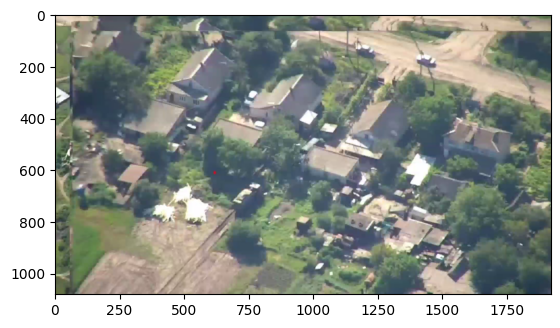

In [48]:
# Apply inpainting to remove OSD
inpaint_result = cv2.inpaint(video[0], filled_image, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
plt.imshow(inpaint_result)

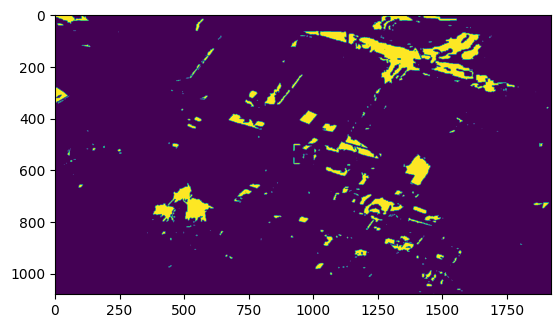

In [24]:
# Load the preprocessed watermark image
watermark_image = cv2.cvtColor(video[0], cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, binary_mask = cv2.threshold(watermark_image, 200, 255, cv2.THRESH_BINARY)

# Save the binary mask
plt.imshow(binary_mask)

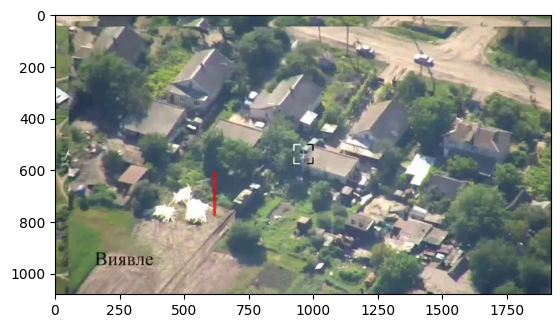

In [19]:
plt.imshow(video[5])

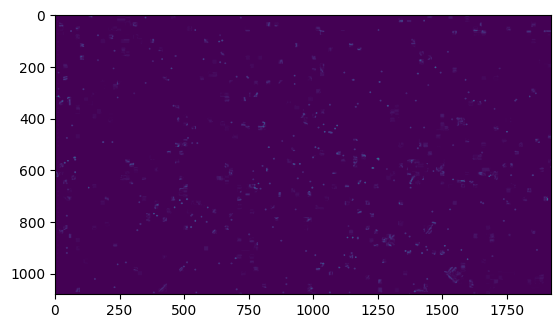

In [15]:
osd_mask = create_osd_mask(video[0], video[1])

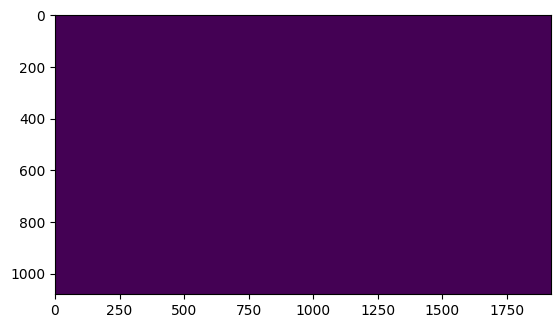

In [11]:
plt.imshow(osd_mask)

In [13]:
osd_mask.sum()

0

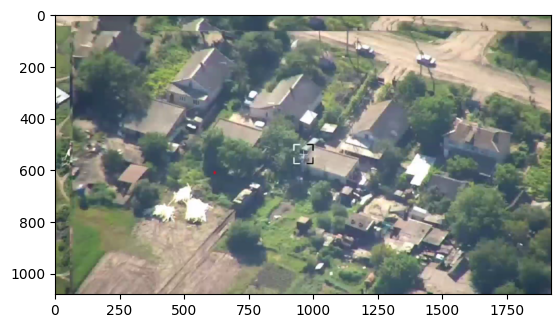

In [65]:
plt.imshow(video[0])

Text(0.5, 1.0, 'Original image')

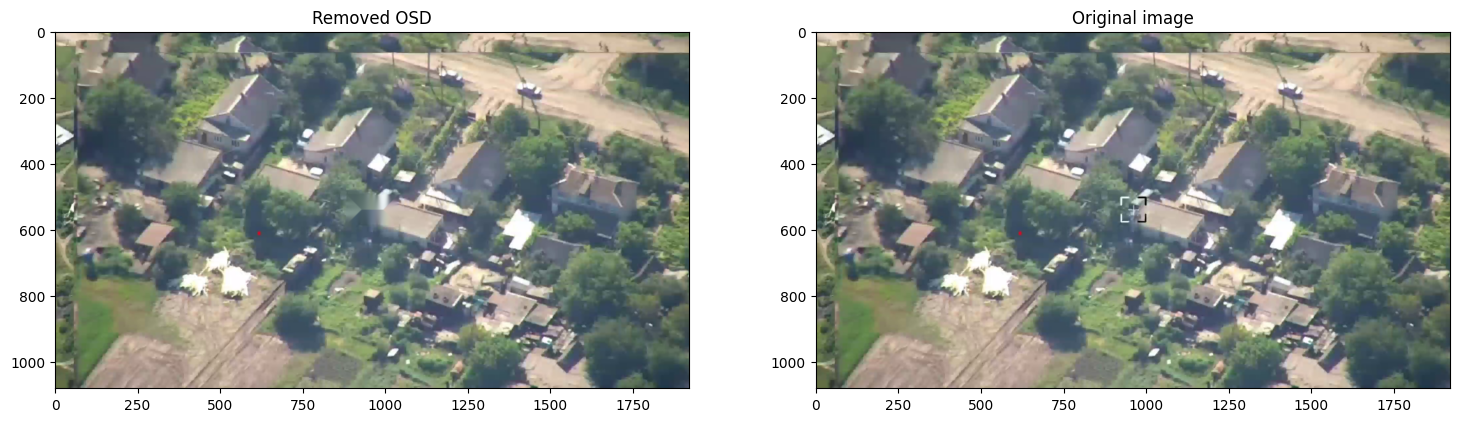

In [69]:
# Define the region containing the OSD
img = video[0]
height, width, _ = img.shape

mask = np.zeros((height, width), dtype=np.uint8)

x_center = height  // 2
y_center = width // 2

x_margin = int(height * 0.05)
y_margin = int(width * 0.05)


# Set the OSD region in the mask to be white (255)
mask[x_center - x_margin: x_center + x_margin, y_center - y_margin : y_center + y_margin] = 255

# Apply inpainting to remove OSD
inpaint_result = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)



plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.imshow(inpaint_result)
plt.title('Removed OSD')

plt.subplot(1, 2, 2)
plt.imshow(img) 
plt.title('Original image')


In [53]:
mask.shape, img.shape

((1080, 1920), (1080, 1920, 3))

In [30]:
cropped_img = crop_center(video[0])

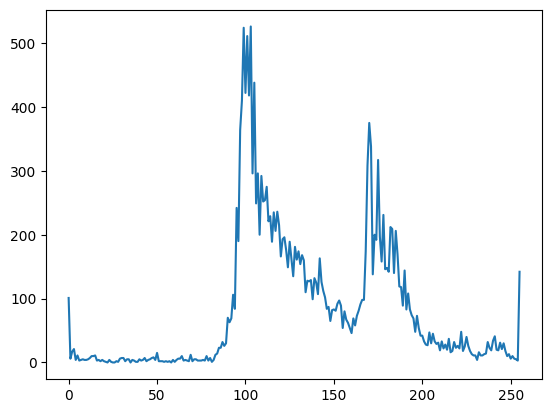

In [33]:

# find frequency of pixels in range 0-255
histr = cv2.calcHist([cropped_img],[0],None,[256],[0,256])
  
# show the plotting graph of an image
plt.plot(histr)
plt.show()

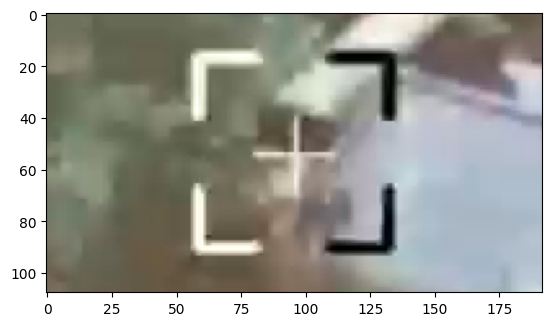

In [25]:
plt.imshow(cropped_img)

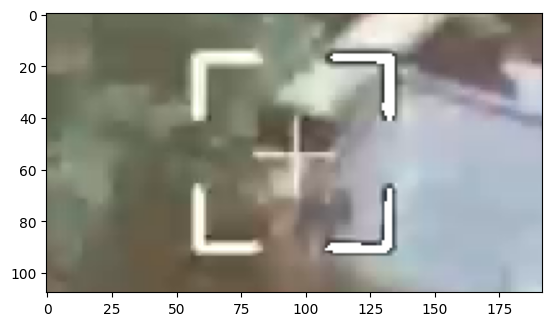

In [39]:
# get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
black_pixels = np.where(
    (cropped_img[:, :, 0] <= 50) & 
    (cropped_img[:, :, 1] <= 50) & 
    (cropped_img[:, :, 2] <= 50)
)

# set those pixels to white
cropped_img[black_pixels] = [255, 255, 255]

plt.imshow(cropped_img)

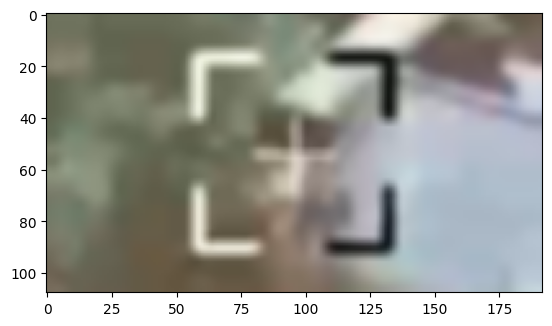

In [29]:
plt.imshow(remove_OSD(crop_center(video[0])))